In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

import copy
import time

import sys
sys.path.extend(["..", "."])
from src.text_data import TokenizedTextClassificationDataset

In [2]:
DEVICE = "cuda:1"
DATA_PATH = "/mnt/ssd/ronak/datasets/"
SCORE_MODEL = "gpt2"

In [3]:
def get_param_shapes(parameters):
    return [torch.tensor(p.shape) for p in parameters]

def get_num_parameters(param_shapes):
    return torch.tensor([torch.prod(s) for s in param_shapes]).sum().item()

def unflatten_gradient(g, param_shapes):
    chunks = list(torch.split(g, [torch.prod(s) for s in param_shapes]))
    for i, chunk in enumerate(chunks):
        chunks[i] = chunk.reshape(tuple(param_shapes[i]))
    return chunks

def flatten_parameters(parameters):
    return torch.cat([p.reshape(-1) for p in parameters])

# vocab size is the CLIP tokenizer by default
class RecurrentNet(nn.Module):

    def __init__(self, n_classes, vocab_size=49408):
        super().__init__()
        embed_dim = 32
        hidden_dim = 32
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.lstm1 = nn.LSTM(embed_dim, hidden_dim, num_layers=1, batch_first=True)
        # self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, num_layers=1, batch_first=True)
        if n_classes == 2:
            self.classifier = nn.Linear(hidden_dim, 1)
        else:
            self.classifier = nn.Linear(hidden_dim, n_classes)

    def forward(self, x):
        h = self.embed(x)
        h = self.lstm1(h)
        # h = self.lstm2(h)
        out = self.classifier(h[0][:, -1, :]) # take last hidden state in the sequence
        return out.squeeze()
    
class GradientModel(nn.Module):

    def __init__(self, n_model_params, n_score_params, hidden_size=512):
        super().__init__()
        self.ffn = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(n_model_params + n_score_params, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, n_model_params),
        )

    def forward(self, g, score):
        # reshape gradient to match the number of scores (batch size)
        g = g.reshape(1, -1).expand([len(score), len(g)])
        x = torch.cat([g, score], dim=1)
        return torch.mean(self.ffn(x), axis=0)

In [4]:
def train_one_epoch_func(dataloader, func_model, func_optimizer):
    func_model.train()
    floss = 0.0
    for i, (idx, x, y) in enumerate(dataloader):
        logits = func_model(x.to(DEVICE))
        loss = F.binary_cross_entropy_with_logits(logits, y.to(DEVICE))
        loss.backward()
        func_optimizer.step()
        func_optimizer.zero_grad()
        floss += loss.item() / len(dataloader)
    return floss

@torch.no_grad()
def evaluate_func(dataloader, func_model):
    func_model.eval()
    floss = 0.0
    acc = 0.0
    for i, (idx, x, y) in enumerate(dataloader):
        logits = func_model(x.to(DEVICE))
        loss = F.binary_cross_entropy_with_logits(logits, y.to(DEVICE))
        floss += loss.item() / len(dataloader)
        acc += torch.mean((y.squeeze().to(DEVICE) == (logits.squeeze() >= 0).int()).float()).item() / len(dataloader)
    return floss, acc

def train_one_epoch_grad(dataloader, func_model, grad_model, grad_optimizer, scores):
    func_model.train()
    grad_model.train()
    param_shapes = get_param_shapes(func_model.parameters())
    full_grad = [torch.zeros(tuple(s), requires_grad=False).to(DEVICE) for s in param_shapes]

    # Use one epoch to compute the full batch gradients.
    for i, (idx, x, y) in enumerate(dataloader):
        func_model.zero_grad()
        logits = func_model(x.to(DEVICE))
        loss = F.binary_cross_entropy_with_logits(logits, y.to(DEVICE))
        grads = torch.autograd.grad(outputs=loss, inputs=func_model.parameters())
        with torch.no_grad():
            for sgrad, fgrad in zip(grads, full_grad):
                fgrad += sgrad.detach() / len(dataloader)
    
    # Use a second epoch to train the gradient model.
    gloss = 0.0
    for i, (idx, x, y) in enumerate(dataloader):

        logits = func_model(x.to(DEVICE))
        loss = F.binary_cross_entropy_with_logits(logits, y.to(DEVICE))
        grads = torch.autograd.grad(outputs=loss, inputs=func_model.parameters())

        targets_true = flatten_parameters(full_grad)
        targets_pred = grad_model(flatten_parameters(grads), scores[idx])
        error = F.mse_loss(targets_pred, targets_true)
        error.backward()

        grad_optimizer.step()
        grad_optimizer.zero_grad()
        gloss += error.item() / len(dataloader)
    return gloss

@torch.no_grad()
def evaluate_grad(dataloader, func_model, grad_model, scores):
    func_model.train()
    grad_model.eval()
    param_shapes = get_param_shapes(func_model.parameters())
    full_grad = [torch.zeros(tuple(s)).to(DEVICE) for s in param_shapes]
    # Use one epoch to compute the full batch gradients.
    for i, (idx, x, y) in enumerate(dataloader):
        func_model.zero_grad()
        with torch.enable_grad():
            logits = func_model(x.to(DEVICE))
            loss = F.binary_cross_entropy_with_logits(logits, y.to(DEVICE))
            grads = torch.autograd.grad(outputs=loss, inputs=func_model.parameters())
        for sgrad, fgrad in zip(grads, full_grad):
            fgrad += sgrad.detach() / len(dataloader)

    gloss = 0.0
    for i, (idx, x, y) in enumerate(dataloader):
        with torch.enable_grad():
            logits = func_model(x.to(DEVICE))
            loss = F.binary_cross_entropy_with_logits(logits, y.to(DEVICE))
            grads = torch.autograd.grad(outputs=loss, inputs=func_model.parameters())

        targets_true = flatten_parameters(full_grad)
        targets_pred = grad_model(flatten_parameters(grads), scores[idx])
        error = F.mse_loss(targets_pred, targets_true)
        gloss += error.item() / len(dataloader)
    return gloss

### Train Gradient Model on SST-2

In [5]:
root = os.path.join(DATA_PATH, "sst2")
# flip so that padding is on the left for LSTM
x_train = np.flip(np.load(os.path.join(root, "x_train.npy")), axis=1).copy()
y_train = np.load(os.path.join(root, "y_train.npy"))
x_test  = np.flip(np.load(os.path.join(root, "x_val.npy")), axis=1).copy()
y_test  = np.load(os.path.join(root, "y_val.npy"))

for dat, name in zip([x_train, y_train, x_test, y_test], ["x_train", "y_train", "x_test", "y_test"]):
    print(f"{name} shape: {dat.shape}")

# load original dataset
batch_size = 128
train_dataset = TokenizedTextClassificationDataset(x_train, y_train)
train_loader = DataLoader(
    train_dataset, shuffle=True, batch_size=batch_size
)
print(f"{len(train_dataset):>5,} training samples.")
val_dataset = TokenizedTextClassificationDataset(x_test, y_test)
val_loader = DataLoader(
    val_dataset, shuffle=True, batch_size=batch_size
)
print(f"{len(val_dataset):>5,} validation samples.")

# load scores

scores = torch.from_numpy(np.load(os.path.join(root, f"{SCORE_MODEL}_scores.npy"))).to(DEVICE)
print(f"scores shape: {tuple(scores.shape)}")

x_train shape: (67349, 77)
y_train shape: (67349,)
x_test shape: (872, 77)
y_test shape: (872,)
67,349 training samples.
  872 validation samples.
scores shape: (67349, 12)


In [6]:
n_epochs = 10
n_classes = 2

func_model = RecurrentNet(n_classes).to(DEVICE)
param_shapes = get_param_shapes(func_model.parameters())
# n_parameters = get_num_parameters(param_shapes)
n_model_params, n_score_params = get_num_parameters(param_shapes), scores.shape[1]
print(f"number of parameters {n_model_params}")
grad_model = GradientModel(n_model_params, n_score_params, hidden_size=16).to(DEVICE)

func_optimizer = torch.optim.Adam(func_model.parameters(), lr=1e-2)
grad_optimizer = torch.optim.Adam(grad_model.parameters(), lr=1e-4)

number of parameters 1589537


In [7]:
func_train_loss = torch.zeros(n_epochs)
grad_train_loss = torch.zeros(n_epochs)
func_val_acc    = torch.zeros(n_epochs)
grad_val_loss   = torch.zeros(n_epochs)

torch.manual_seed(123)
for epoch in range(n_epochs):
    # train the function model for one epoch to learn the parameters
    func_train_loss[epoch] = train_one_epoch_func(train_loader, func_model, func_optimizer)
    print(f"func train loss epoch {epoch:02d}: {func_train_loss[epoch]:0.5f}")
    _, func_val_acc[epoch] = evaluate_func(val_loader, func_model)
    print(f"func valid acc epoch {epoch:02d}:  {func_val_acc[epoch]:0.5f}")

    # train the gradient model for one epoch
    grad_train_loss[epoch] = train_one_epoch_grad(train_loader, func_model, grad_model, grad_optimizer, scores)
    print(f"grad train loss epoch {epoch:02d}: {grad_train_loss[epoch]:0.5f}")
    grad_val_loss[epoch] = evaluate_grad(val_loader, func_model, grad_model, scores)
    print(f"grad valid loss epoch {epoch:02d}: {grad_val_loss[epoch]:0.5f}")
    print()

func train loss epoch 00: 0.38485
func valid acc epoch 00:  0.82074
grad train loss epoch 00: 0.01516
grad valid loss epoch 00: 0.00925

func train loss epoch 01: 0.19329
func valid acc epoch 01:  0.83070
grad train loss epoch 01: 0.00478
grad valid loss epoch 01: 0.00163

func train loss epoch 02: 0.13309
func valid acc epoch 02:  0.82667
grad train loss epoch 02: 0.00066
grad valid loss epoch 02: 0.00019

func train loss epoch 03: 0.10215
func valid acc epoch 03:  0.82280
grad train loss epoch 03: 0.00009
grad valid loss epoch 03: 0.00004

func train loss epoch 04: 0.08092
func valid acc epoch 04:  0.82048
grad train loss epoch 04: 0.00005
grad valid loss epoch 04: 0.00004

func train loss epoch 05: 0.06658
func valid acc epoch 05:  0.82838
grad train loss epoch 05: 0.00004
grad valid loss epoch 05: 0.00002

func train loss epoch 06: 0.05878
func valid acc epoch 06:  0.81027
grad train loss epoch 06: 0.00004
grad valid loss epoch 06: 0.00002

func train loss epoch 07: 0.05037
func va

Text(0, 0.5, 'Validation Loss')

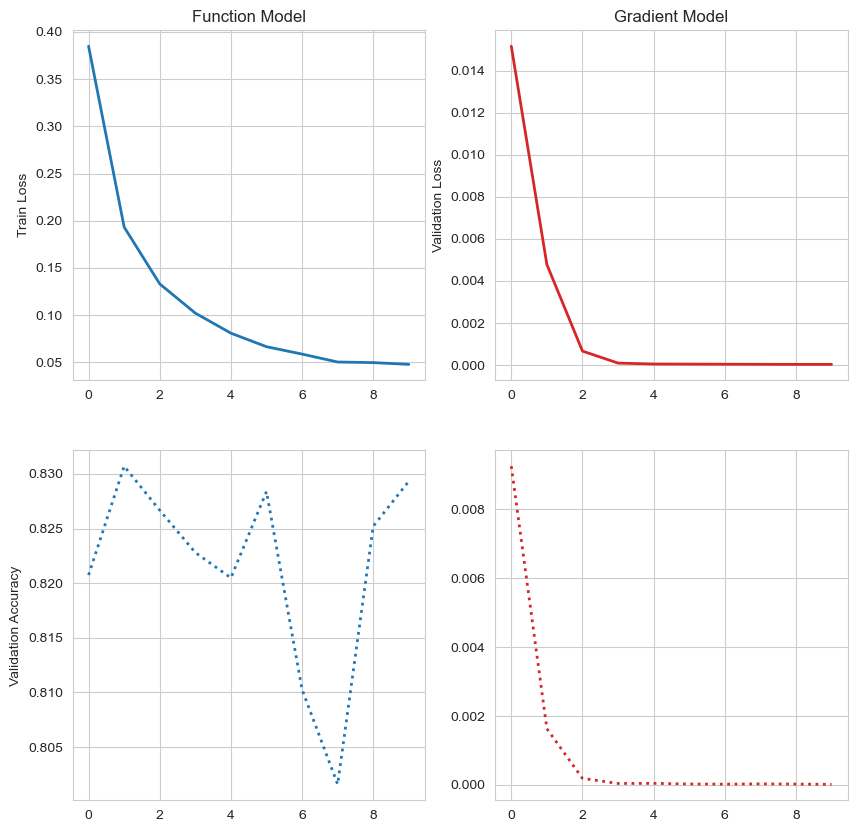

In [10]:
sns.set_style("whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

t = np.arange(n_epochs)

axes[0, 0].plot(t, func_train_loss, color="tab:blue", linewidth=2, linestyle="solid")
axes[0, 1].plot(t, grad_train_loss, color="tab:red", linewidth=2, linestyle="solid")
axes[1, 0].plot(t, func_val_acc, color="tab:blue", linewidth=2, linestyle="dotted")
axes[1, 1].plot(t, grad_val_loss, color="tab:red", linewidth=2, linestyle="dotted")

axes[0, 0].set_title("Function Model")
axes[0, 1].set_title("Gradient Model")

axes[0, 0].set_ylabel("Train Loss")
axes[0, 1].set_ylabel("Train Loss")
axes[1, 0].set_ylabel("Validation Accuracy")
axes[0, 1].set_ylabel("Validation Loss")

In [11]:
torch.save(grad_model.state_dict(), os.path.join(root, "grad_model.pt"))

### Re-Train Model on SST-2 Using Gradient Predictions

In [30]:
DEVICE = "cuda:2"
n_classes = 2
root = os.path.join(DATA_PATH, "sst2")

scores = torch.from_numpy(np.load(os.path.join(root, f"{SCORE_MODEL}_scores.npy"))).to(DEVICE)
print(f"scores shape: {tuple(scores.shape)}")

model = RecurrentNet(n_classes).to(DEVICE)
param_shapes = get_param_shapes(model.parameters())
n_model_params, n_score_params = get_num_parameters(param_shapes), scores.shape[1]
print(f"number of parameters {n_model_params}")

gmodel = GradientModel(n_model_params, n_score_params, hidden_size=16).to(DEVICE)
gmodel.load_state_dict(torch.load(os.path.join(root, "grad_model.pt")))
gmodel.eval()

goptimizer = torch.optim.Adam(gmodel.parameters(), lr=1e-4)

scores shape: (67349, 12)
number of parameters 1589537


In [45]:
# flip so that padding is on the left for LSTM
x_train = np.flip(np.load(os.path.join(root, "x_train.npy")), axis=1).copy()
y_train = np.load(os.path.join(root, "y_train.npy"))
x_test  = np.flip(np.load(os.path.join(root, "x_val.npy")), axis=1).copy()
y_test  = np.load(os.path.join(root, "y_val.npy"))

for dat, name in zip([x_train, y_train, x_test, y_test], ["x_train", "y_train", "x_test", "y_test"]):
    print(f"{name} shape: {dat.shape}")

# load original dataset
batch_size = 128
train_dataset = TokenizedTextClassificationDataset(x_train, y_train)
train_loader = DataLoader(
    train_dataset, shuffle=True, batch_size=batch_size
)
print(f"{len(train_dataset):>5,} training samples.")
val_dataset = TokenizedTextClassificationDataset(x_test, y_test)
val_loader = DataLoader(
    val_dataset, shuffle=True, batch_size=batch_size
)
print(f"{len(val_dataset):>5,} validation samples.")

x_train shape: (67349, 77)
y_train shape: (67349,)
x_test shape: (872, 77)
y_test shape: (872,)
67,349 training samples.
  872 validation samples.


In [55]:
n_epochs = 5
lr = 0.1
mu = 0.0
lam = 0.2
param_shapes = get_param_shapes(model.parameters())

with torch.no_grad():

    train_loss = torch.zeros(n_epochs)
    train_acc  = torch.zeros(n_epochs)
    val_loss   = torch.zeros(n_epochs)
    val_acc    = torch.zeros(n_epochs)

    torch.manual_seed(123)

    total_time = 0.0
    momentum = [torch.zeros(tuple(s)).to(DEVICE) for s in param_shapes]
    for epoch in range(n_epochs):
        tic = time.time()
        if epoch > 0 and epoch % 5 == 0:
            print(f"epoch {epoch}: refitting gradient model...")
            with torch.enable_grad():
                gloss = train_one_epoch_grad(train_loader, model, gmodel, goptimizer, scores)
            print(f"epoch {epoch}: {gloss:0.6f} grad loss")

        gmodel.eval()
        model.train()
        for i, (idx, x, y) in enumerate(train_loader):
            model.zero_grad()
            with torch.enable_grad():
                logits = model(x.to(DEVICE))
                loss = F.binary_cross_entropy_with_logits(logits, y.to(DEVICE))
                sgrads = torch.autograd.grad(outputs=loss, inputs=model.parameters())
            grads = gmodel(flatten_parameters(sgrads), scores[idx])
            grads = unflatten_gradient(grads, param_shapes)

            for j, (p, g, m, s) in enumerate(zip(model.parameters(), grads, sgrads, momentum)):
                # g = (1 - lam) * s + lam * g
                if epoch == 0:
                    g = s # use regular sgd for the first epoch
                    print(g)
                    print(s)
                    raise ValueError("lol")
                if j == 0 and i == 0:
                    print(p)
                if mu > 0.0:
                    p.copy_(p - lr * (g + mu * m))
                    m.copy_(g)
                else:
                    p.copy_(p - lr * g)

        toc = time.time()
        total_time += (toc - tic)

        train_loss[epoch], train_acc[epoch] = evaluate_func(train_loader, model)
        val_loss[epoch], val_acc[epoch] = evaluate_func(val_loader, model)

        print(f"epoch {epoch}: train loss: {train_loss[epoch]:0.5f}")
        print(f"epoch {epoch}: train acc:  {train_acc[epoch]:0.5f}")
        print(f"epoch {epoch}: valid loss: {val_loss[epoch]:0.5f}")
        print(f"epoch {epoch}: valid acc:  {val_acc[epoch]:0.5f}")
        print()


print(total_time)
print(train_loss)
print(train_acc)
print(val_loss)
print(val_acc)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:2')
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:2')


ValueError: lol

### Plot RB-SGD performance against SGD

In [4]:
func_train_loss = torch.load("sst2_sgd_func_train_loss.pt")
func_train_acc = torch.load("sst2_sgd_func_train_acc.pt")
func_val_loss = torch.load("sst2_sgd_func_val_loss.pt")
func_val_acc = torch.load("sst2_sgd_func_val_acc.pt")

train_loss = torch.load("sst2_rbsgd_train_loss.pt")
train_acc = torch.load("sst2_rbsgd_train_acc.pt")
val_loss = torch.load("sst2_rbsgd_val_loss.pt")
val_acc = torch.load("sst2_rbsgd_val_acc.pt")

Text(0.5, 0.98, 'Binary Classification Performance on SST-2')

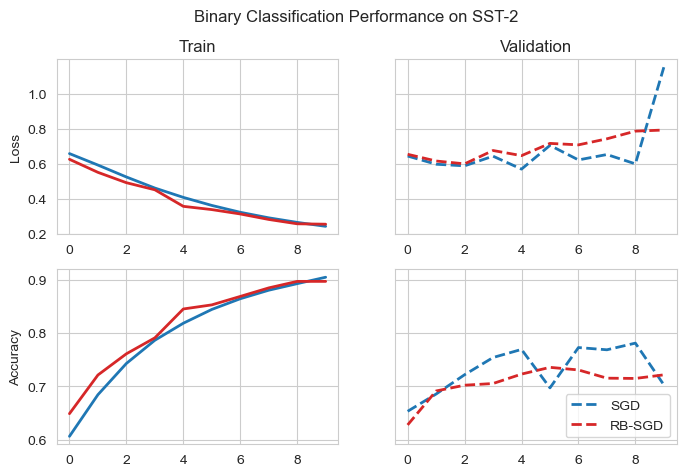

In [10]:
sns.set_style("whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(8, 5), sharey="row")

t = np.arange(len(func_train_loss))

axes[0, 0].plot(t, func_train_loss, color="tab:blue", linewidth=2, linestyle="solid")
axes[0, 0].plot(t, train_loss, color="tab:red", linewidth=2, linestyle="solid")

axes[0, 1].plot(t, func_val_loss, color="tab:blue", linewidth=2, linestyle="dashed")
axes[0, 1].plot(t, val_loss, color="tab:red", linewidth=2, linestyle="dashed")

axes[1, 0].plot(t, func_train_acc, color="tab:blue", linewidth=2, linestyle="solid")
axes[1, 0].plot(t, train_acc, color="tab:red", linewidth=2, linestyle="solid")

axes[1, 1].plot(t, func_val_acc, color="tab:blue", linewidth=2, linestyle="dashed", label="SGD")
axes[1, 1].plot(t, val_acc, color="tab:red", linewidth=2, linestyle="dashed", label="RB-SGD")
axes[1, 1].legend(loc="lower right")

axes[0, 0].set_title("Train")
axes[0, 1].set_title("Validation")

axes[0, 0].set_ylabel("Loss")
axes[1, 0].set_ylabel("Accuracy")

fig.suptitle("Binary Classification Performance on SST-2")